# **🏥 Hospital Readmission Prediction: Data Cleaning & Exploratory Analysis**
**General Assembly Singapore** | **Project 4**: *Data Analytics Bootcamp Capstone Project*  
**Part 1: Data Cleaning & Exploratory Data Analysis (EDA)**

**Author:** Myo Myint Aung (Jimmy) | **Date:** 06 November 2025

---

## **📘 Project Overview**

This notebook documents a **comprehensive, step-by-step data cleaning and exploratory analysis workflow** for predicting 30-day hospital readmissions among diabetic patients.  
The dataset, sourced from Kaggle, covers 10 years of inpatient admissions and includes detailed clinical, demographic, and outcome variables.

*This project was chosen based on my background in biopharmaceutical manufacturing and clinical trial industry experience.*

**Key goals for Part 1:**
- Acquire and validate the dataset (manual and API methods)
- Rigorously clean the data: handle duplicates, missing values, and ambiguous placeholders
- Standardize data types and normalize categorical/Boolean fields
- Identify and remove only the most extreme outliers using domain-driven rules
- Summarize the cleaned dataset and confirm readiness for modeling
- Perform targeted EDA to visualize feature distributions and their relationship to readmission risk

---

## **🎯 Project Objective**

Build a **transparent, interpretable machine learning model** to predict the likelihood of 30-day hospital readmission.  
**Deliverables for Part 1 (this notebook):**
- Fully reproducible data cleaning pipeline with clear justifications for each step
- Visual and statistical summaries of all key features
- Actionable insights to guide feature engineering and modeling in subsequent phases

**Final project deliverables (Parts 2+):**
- Feature importance and risk driver explanations
- Model comparison (baseline and improved)
- Interactive dashboard (Power BI/Tableau) for risk stratification
- Streamlit app for public demo

**Emphasis:**  
Clarity, reproducibility, and actionable insights — not just model accuracy.

---

## **🗂️ Notebook Structure**

1. **Data Acquisition & Validation**  
    - Download via manual and API methods  
    - File integrity and equivalence checks

2. **Data Cleaning & Preparation**  
    - Duplicate and missing value checks  
    - Standardization of placeholder/missing text  
    - Data type normalization (categorical, Boolean)  
    - Outlier detection and removal (domain-driven)

3. **Dataset Readiness & Summary**  
    - Structure, value ranges, class balance, and duplicates  
    - Confirmation of data integrity

4. **Exploratory Data Analysis (EDA)**  
    - Visualizations of target distribution  
    - Feature-wise analysis (categorical & numeric)  
    - Early insights for feature selection and engineering

**This notebook provides a robust foundation for all subsequent modeling and interpretation steps.**  
All code, decisions, and results are fully documented for transparency and reproducibility.

------

## **📂 Data Acquisition Plan**

The dataset is sourced from **Kaggle – dubradave / hospital-readmissions**  
➡️ [https://www.kaggle.com/datasets/dubradave/hospital-readmissions](https://www.kaggle.com/datasets/dubradave/hospital-readmissions)

Each record represents one inpatient admission of a diabetic patient over a 10-year span. The dataset covers hospital readmission outcomes and related metrics. 
The target variable is **`readmitted`** (Yes / No), indicating whether the patient was readmitted within 30 days.

Two acquisition methods were considered:

1. **Manual Download (ZIP file)** – dataset downloaded from the Kaggle webpage and extracted into `data/hospital_readmissions.csv`.  
2. **Kaggle API Download** – via the Kaggle command-line tool:
   ```bash
   kaggle datasets download -d dubradave/hospital-readmissions
   
-----

### **📦 Download via Kaggle API (To compare Local CSV vs API CSV)**
I will use the Kaggle CLI to download the same CSV into `data/api/`, then compare it with my existing file in `data/`.

In [1]:
# I will install kaggle for this notebook kernel
# Install kaggle using the Jupyter magic command
%pip install -q kaggle
print("kaggle installed ✅")

Note: you may need to restart the kernel to use updated packages.
kaggle installed ✅


In [2]:
# I will check that my kaggle.json is in ../data/api/kaggle.json and has the right keys
from pathlib import Path
import json

kaggle_folder = Path("../data/api")          # folder that contains kaggle.json file 
kaggle_path   = kaggle_folder / "kaggle.json"

print("Found file?", kaggle_path.exists(), "->", kaggle_path.resolve())

with open(kaggle_path, "r", encoding="utf-8") as f:
    cfg = json.load(f)

print("Keys present:", list(cfg.keys()))
print("Has username?", bool(cfg.get("username")))
print("Has key?", bool(cfg.get("key")))

Found file? True -> C:\Users\USER\GA Bootcamp Study\Week7\Python\Project4_CapstoneProject\MainWorkArea\data\api\kaggle.json
Keys present: ['username', 'key']
Has username? True
Has key? True


In [3]:
# I will point Kaggle CLI to the folder that contains kaggle.json and download the dataset
import os, subprocess
from pathlib import Path

kaggle_folder = Path("../data/api").resolve()  
os.environ["KAGGLE_CONFIG_DIR"] = str(kaggle_folder)
print("KAGGLE_CONFIG_DIR set to:", os.environ["KAGGLE_CONFIG_DIR"])

dest = Path("../data/api")
dest.mkdir(parents=True, exist_ok=True)

cmd = [
    "kaggle", "datasets", "download",
    "-d", "dubradave/hospital-readmissions",
    "-p", str(dest),
    "--unzip"
]
print("Running:", " ".join(cmd))
proc = subprocess.run(cmd, capture_output=True, text=True, shell=False)
print(proc.stdout or proc.stderr)

# I will list any CSVs downloaded
list(dest.glob("*.csv"))

KAGGLE_CONFIG_DIR set to: C:\Users\USER\GA Bootcamp Study\Week7\Python\Project4_CapstoneProject\MainWorkArea\data\api
Running: kaggle datasets download -d dubradave/hospital-readmissions -p ..\data\api --unzip
Dataset URL: https://www.kaggle.com/datasets/dubradave/hospital-readmissions
License(s): other




[WindowsPath('../data/api/hospital_readmissions.csv')]

In [4]:
# Step 3 — Download the dataset via Kaggle CLI (beginner-friendly version)
import os
from pathlib import Path

# Set up Kaggle API credentials location
os.environ["KAGGLE_CONFIG_DIR"] = "../data/api"
print("Using token from: ../data/api/kaggle.json")

# Download and unzip the dataset
!kaggle datasets download -d dubradave/hospital-readmissions -p ../data/api --unzip

# List downloaded CSV files
import glob
csvs = glob.glob("../data/api/*.csv")
print("CSV files found:", [os.path.basename(f) for f in csvs])
[os.path.basename(f) for f in csvs][:3]


Using token from: ../data/api/kaggle.json
Dataset URL: https://www.kaggle.com/datasets/dubradave/hospital-readmissions
License(s): other

CSV files found: ['hospital_readmissions.csv']



  0%|          | 0.00/286k [00:00<?, ?B/s]
100%|██████████| 286k/286k [00:00<00:00, 351MB/s]


['hospital_readmissions.csv']

-----
### 🆚 **Comparing API CSV vs Local CSV**

In [5]:
# Compare API copy vs local CSV for equivalence (simplified)
import pandas as pd
import hashlib

local_path = "../data/hospital_readmissions.csv"
api_path   = "../data/api/hospital_readmissions.csv"

print("Local exists:", pd.io.common.file_exists(local_path), "| API exists:", pd.io.common.file_exists(api_path))

local_df = pd.read_csv(local_path)
api_df   = pd.read_csv(api_path)

print("Shapes (local, api):", local_df.shape, api_df.shape)
print("Same columns?       ", set(local_df.columns) == set(api_df.columns))

# I will compute a simple fingerprint (order-agnostic by sorting columns)
def fingerprint(df):
    df2 = df.reindex(sorted(df.columns), axis=1)
    b   = df2.to_csv(index=False).encode("utf-8")
    return hashlib.md5(b).hexdigest()

print("MD5 (local):", fingerprint(local_df))
print("MD5 (api):  ", fingerprint(api_df))


Local exists: True | API exists: True
Shapes (local, api): (25000, 17) (25000, 17)
Same columns?        True
MD5 (local): b63c95a785b9026a9d10190e42f508b8
MD5 (api):   b63c95a785b9026a9d10190e42f508b8


-----

### **🧾 Load and Inspect Dataset Structure**

I will load the CSV file, view its shape and column names, and check a few rows to confirm it loaded correctly.  
This helps me verify the dataset is complete and ready for validation.

In [6]:
# I will import basic libraries
import pandas as pd
import numpy as np

# I will set pandas display options to view more columns
pd.set_option("display.max_columns", 100)

# I will load the CSV file
csv_path = "../data/hospital_readmissions.csv"   
hosp_df = pd.read_csv(csv_path)

# I will print the basic structure
print(f"Dataset shape: {hosp_df.shape[0]} rows × {hosp_df.shape[1]} columns")
print("\nColumn names:")
print(hosp_df.columns.tolist())

# I will peek at the first 3 rows
hosp_df.head(3)

Dataset shape: 25000 rows × 17 columns

Column names:
['age', 'time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med', 'readmitted']


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes


---
## **🧹 Step 1 — Data Cleaning & Preparation**
- I will perform the following data cleaning steps: check for duplicate rows, check for missing values, scan for placeholder “missing” text values, standardize placeholder text, review data types, and normalize “yes/no” columns to Boolean in Step 1.
---



### 🧐 **Step 1A — Check for duplicate rows**

I will check whether any rows are exact duplicates. If found, I will report how many and remove them once confirmed.

In [7]:
# Check for and report duplicate rows, then preview a few if found
dup_count = hosp_df.duplicated().sum()
print(f"Number of duplicate rows: {dup_count}")

if dup_count > 0:
    print("Previewing duplicate rows:")
    display(hosp_df[hosp_df.duplicated()].head(3))
dup_count = hosp_df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")

Number of duplicate rows: 0
Duplicate rows: 0


**✅Result – Duplicate Check**

- I examined the dataset for any exact duplicate rows, which could indicate data entry or processing errors.
- **Duplicates found:** 0  

**🟢Action:** No duplicate rows were detected, so no removal was necessary. Each record in the dataset is unique, allowing me to confidently proceed to the next data cleaning step.

-----
### 🧐 **Step 1B — Check missing values**

I will count missing values (NaN) per column, compute percentages, and list the top columns with missing data.

In [8]:
# Count missing values for each column
missing_counts = hosp_df.isna().sum()
missing_percent = (missing_counts / len(hosp_df)) * 100

# Combine into a DataFrame for easy viewing
na_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_pct": missing_percent.round(2)
})

# Sort by percentage of missing values (highest first)
na_summary = na_summary.sort_values("missing_pct", ascending=False)

print(f"Rows: {len(hosp_df)}")
display(na_summary.head(10))  # Show top 10 columns with most missing values

Rows: 25000


,missing_count,missing_pct
age,0,0.0
time_in_hospital,0,0.0
n_lab_procedures,0,0.0
n_procedures,0,0.0
n_medications,0,0.0
n_outpatient,0,0.0
n_inpatient,0,0.0
n_emergency,0,0.0
medical_specialty,0,0.0
diag_1,0,0.0


**✅Result – Missing Value Check**

- I examined all columns in the dataframe for missing values (NaN).
- **Missing Values Found:** 0  
- **Explanation:** Every column in the dataset is fully populated, with no missing entries detected.

**🟢Action:** No further action is required for missing data. The dataset is complete and ready for the next step.

----
### 🧐 **Step 1C- Check placeholder “missing” text values**

Even if there are no NaNs, some text columns may use placeholders like “Missing”, “Unknown”, “None”, or “?”. I will scan object columns for these and report counts.

In [9]:
# I will look for placeholder missing values in text columns
tokens = ["missing", "unknown", "none", "?", "na", "n/a", "null"]
results = []

for col in hosp_df.select_dtypes(include="object").columns:            #.select_dtypes(include="object") to limit to text columns only
    col_lower = hosp_df[col].astype(str).str.strip().str.lower() 
          # .astype(str) to avoid errors on non-string entries, .str.strip() to remove leading/trailing spaces, .str.lower() for case-insensitive matching
    count = col_lower.isin(tokens).sum()             # col_lower.isin(tokens) to count occurrences of placeholder tokens
    if count > 0:
        percent = round(count / len(hosp_df) * 100, 2)   # to calculate percentage of placeholder values 
        results.append([col, count, percent])            # .append([col, count, percent]) to store results of columns with placeholders

# Create a DataFrame only if there are results, else show empty DataFrame
if results:
    placeholder_summary = pd.DataFrame(results, columns=["column", "count", "pct"])
    placeholder_summary = placeholder_summary.sort_values("count", ascending=False)
else:
    placeholder_summary = pd.DataFrame(columns=["column", "count", "pct"])
display(placeholder_summary)


,column,count,pct
0,medical_specialty,12382,49.53
3,diag_3,196,0.78
2,diag_2,42,0.17
1,diag_1,4,0.02


**✅Result – Placeholder “missing” values**

I checked all text columns for special words that mean missing data (`Missing`, `Unknown`, `None`, `?`, `NA`, `N/A`, `Null`).

- **medical_specialty**: About half the rows (**12,382** or **49.53%**) are marked as “Missing” or “Unknown”.
- **diag_3**: **196** rows (**0.78%**) have a missing value.
- **diag_2**: **42** rows (**0.17%**) have a missing value.
- **diag_1**: **4** rows (**0.02%**) have a missing value.
- All other text columns do not have any important missing values.

**What this means:**  
There are no empty (NaN) cells, but some columns use the word “Missing” to show that information is not available. This is most common in `medical_specialty` (almost half the data), and a small number of diagnosis fields.

**What I will do:**  
I will treat these “Missing” entries as real missing values. In the next step, I will change them to "unknown" so they are handled properly when I clean and analyze the data. Later, I might keep a special “Unknown” group if it helps the model.

-----
### 🩺 **Step 1D — Standardizing Placeholder and Missing-Like Text Values**

**Goal**  
To ensure data quality and consistency, I will standardize all placeholder or missing-like text values (such as “Missing”, “Unknown”, “NA”, or blanks) in key categorical columns by replacing them with a single, clear label: “unknown”. This approach makes missing information explicit and ensures it is handled consistently throughout analysis and modeling.

**Why This Matters**  
- **Prevents Data Loss:** Retains all patient records by marking missing information, rather than dropping rows with incomplete data.
- **Improves Consistency:** Consolidates various placeholder terms into one standard label (“unknown”), reducing ambiguity in categorical variables.
- **Facilitates Analysis & Modeling:** Standardized categories simplify data exploration, visualization, and encoding, leading to more reliable and interpretable results.
- **Enhances Interpretability:** Clearly distinguishes between truly missing data (“unknown”) and valid but rare categories (“other”), supporting transparent reporting and model explanations.

**Approach**  
I will replace all placeholder or missing-like values with “unknown” in the following columns:
- **medical_specialty:** Indicates the physician’s specialty was not recorded. This avoids guessing or mislabeling and keeps missing data explicit.
- **diag_1 (primary diagnosis):** Ensures every admission has a defined main diagnosis, even if missing.
- **diag_2, diag_3 (secondary diagnoses):** Captures cases where secondary diagnoses are not available or not applicable.

All replacements will be case-insensitive and will handle extra spaces or common placeholder words.


In [10]:
# --- Step 1D: Standardize placeholder text to "unknown" ---

# 1) Columns to clean
cols = ["medical_specialty", "diag_1", "diag_2", "diag_3"]

# 2) Words that mean "missing" (case-insensitive)
placeholders = ["missing", "unknown", "na", "n/a", "none", "null", "?"]

# 3) Replace any placeholder or blank/NaN with "unknown" (case-insensitive)
for col in cols:
    hosp_df[col] = hosp_df[col].astype(str).str.strip().str.lower()             # to lowercase and strip spaces for uniformity for all rows 
    hosp_df[col] = hosp_df[col].replace(placeholders + ["", "nan"], "unknown")

# 4) Quick checks
print("Remaining NaNs per column (should be 0):")
print(hosp_df[cols].isna().sum())

print("\nRemaining blank strings per column (should be 0):")
print((hosp_df[cols] == "").sum())

# 5) Peek at the most common values to confirm the change
for c in cols:
    print(f"\nTop values — {c}")
    print(hosp_df[c].value_counts().head(10))


Remaining NaNs per column (should be 0):
medical_specialty    0
diag_1               0
diag_2               0
diag_3               0
dtype: int64

Remaining blank strings per column (should be 0):
medical_specialty    0
diag_1               0
diag_2               0
diag_3               0
dtype: int64

Top values — medical_specialty
medical_specialty
unknown                   12382
internalmedicine           3565
other                      2664
emergency/trauma           1885
family/generalpractice     1882
cardiology                 1409
surgery                    1213
Name: count, dtype: int64

Top values — diag_1
diag_1
circulatory        7824
other              6498
respiratory        3680
digestive          2329
diabetes           1747
injury             1666
musculoskeletal    1252
unknown               4
Name: count, dtype: int64

Top values — diag_2
diag_2
other              9056
circulatory        8134
diabetes           2906
respiratory        2872
digestive           973
inju

**✅ Result – Placeholder “Missing” Values Normalized**
- **medical_specialty:** 12,382 rows (49.53%) previously marked as “Missing”, or similar placeholders are now replaced with the standardized category `unknown`.
- **diag_1:** 4 rows (0.02%) previously marked as “Missing” or similar are now replaced with `unknown`.
- **diag_2:** 42 rows (0.17%) previously marked as “Missing” or similar are now replaced with `unknown`.
- **diag_3:** 196 rows (0.78%) previously marked as “Missing” or similar are now replaced with `unknown`.
- The category *“unknown”* is now explicit and interpretable, and is **not** treated as missing.
- All other text columns have no placeholder missing values.
- No blank or ambiguous values remain in these key columns.

**🟢 Actions Taken:**
- All placeholder values in `medical_specialty`, `diag_1`, `diag_2`, and `diag_3` were replaced with the clear, standardized value `unknown` for consistency.
- No values were set to NaN; ambiguous entries are now explicit categories.
- No data was dropped at this stage—only ambiguous values were clarified.

**🔎 Why This Matters:**
- Improves data quality and consistency for downstream analysis and modeling.
- Prevents accidental misinterpretation of placeholder text as valid categories.
- Ensures that missingness is handled transparently and can be addressed appropriately in feature engineering or modeling.

**➡️ Next Step:**  
Proceed to review and standardize data types for all columns, ensuring numeric and categorical fields are correctly recognized by pandas. This will support robust analysis and modeling in subsequent steps.

----
### **🧩 Step 1E — Review Data Types and Basic Standardization**

Now that missing values are cleaned, I will review each column’s data type to ensure that numeric and categorical fields are correctly recognized by pandas. This helps prevent modeling errors later.

In [ ]:
# I will review the data types of all columns
hosp_df.info()

# I will list all text columns/categorical (object type) for review
text_columns = [col for col in hosp_df.columns if hosp_df[col].dtype == "object"]
print("\nText columns:", text_columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

**✅Result – Data Type Review**

- All numeric columns (such as `n_lab_procedures`, `n_procedures`, `time_in_hospital`, etc.) are correctly stored as numbers.
- Categorical columns (like `age`, `medical_specialty`, and `diag_1`–`diag_3`) are currently stored as text (`object` type). For modeling, I will convert these to the pandas `category` type for efficiency and clarity.
- If needed for machine learning algorithms, I will apply one-hot encoding to these categorical columns to convert them into a suitable numeric format. Any columns with numbers stored as text will also be converted to numeric types before modeling.

---
#### 🟦 **Step 1F — Normalize “Yes/No” columns to Boolean**

I will identify columns that contain binary responses (“yes” / “no”) and convert them into pandas’ nullable Boolean type for consistency and easier analysis.

This standardization ensures that all true/false variables are treated the same way, making downstream analysis and modeling more reliable.

- **Columns to convert:**  
    `change`, `diabetes_med`, and `readmitted` will be mapped to Boolean values (`True` for "yes", `False` for "no").

- **Columns to keep as categorical:**  
    `glucose_test` and `A1Ctest` will remain as categorical variables, since they include more than two possible values (e.g., "high", "normal", "no") and are not strictly binary.

After conversion, I will check the unique values and data types to confirm that the transformation was successful.

In [12]:
# Step 1F — Normalize Yes/No columns to Boolean dtype
bin_cols = ["change", "diabetes_med", "readmitted"]

# Show original unique values
for col in bin_cols:
    print(f"\nBefore — {col} value counts:")
    print(hosp_df[col].value_counts(dropna=False))

# Convert "yes" to True, "no" to False (case-insensitive)
for col in bin_cols:
    hosp_df[col] = hosp_df[col].str.strip().str.lower().map({"yes": True, "no": False}).astype("boolean")

# Show results after conversion
for col in bin_cols:
    print(f"\nAfter — {col} dtype: {hosp_df[col].dtype}")
    print(hosp_df[col].value_counts(dropna=False))



Before — change value counts:
change
no     13497
yes    11503
Name: count, dtype: int64

Before — diabetes_med value counts:
diabetes_med
yes    19228
no      5772
Name: count, dtype: int64

Before — readmitted value counts:
readmitted
no     13246
yes    11754
Name: count, dtype: int64

After — change dtype: boolean
change
False    13497
True     11503
Name: count, dtype: Int64

After — diabetes_med dtype: boolean
diabetes_med
True     19228
False     5772
Name: count, dtype: Int64

After — readmitted dtype: boolean
readmitted
False    13246
True     11754
Name: count, dtype: Int64


**✅ Result – Boolean Standardization**

- The columns `change`, `diabetes_med`, and `readmitted` have been successfully converted from text values ("yes" / "no") to pandas’ Boolean data type (`True` / `False` with `<NA>` support).
- This conversion ensures all binary fields are consistent, eliminates issues with case or extra spaces, and makes these columns easier to use for analysis, encoding, and modeling.
- The columns `glucose_test` and `A1Ctest` remain as categorical variables because they contain more than two possible values (such as "high", "normal", and "no") and are not strictly binary.
- Quick checks using `.value_counts()` confirm that all values were mapped correctly and no unexpected categories remain.

**🟢 Action**
Boolean columns are now standardized. The next step will focus on checking for outliers in numerical features using boxplots, to identify and handle any extreme values that could distort model training.

---------------


## 🗂️✨ **Step 2 — Dataset Readiness & First Look**

- Quality checks (Step 2A– Step 2D) to make the data reliable, followed by a quick visual scan (Step 2E) to guide which features are worth keeping for modeling.

---

### **📊 Step 2A — Check for Outliers (IQR method)**

#### **Goal**

Screen all numeric features for potential outliers using the interquartile range (IQR) method. This process produces a ranked table of columns with outliers, so I can focus visualizations only on relevant features and keep the notebook concise.



#### **Method**

For each numeric column:

- **Q1** = 25th percentile  
- **Q3** = 75th percentile  
- **IQR** = Q3 − Q1

Calculate outlier fences:
- **Lower fence** = Q1 − 1.5 × IQR  
- **Upper fence** = Q3 + 1.5 × IQR

Any value below the lower fence or above the upper fence is flagged as a potential outlier.



#### **Outputs**

- **outlier_summary**: A table that shows how many outliers each column has, and what percent of the data they are.
- **cols_with_outliers**: A list of columns that have any outliers (to use for making boxplots next).
- **iqr_bounds**: A dictionary with the lower and upper limits for each column, which can help if I want to remove or cap outliers later.


In [13]:
# Step 2A — Simple IQR outlier check for all numeric columns

# 1. Get numeric columns
num_cols = hosp_df.select_dtypes(include="number").columns.tolist()
print("Numeric columns:", num_cols)

Numeric columns: ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']


In [14]:
# 2. For each column, find outliers using IQR
outlier_rows = []
iqr_bounds = {}

for col in num_cols:
    s = hosp_df[col]
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    iqr_bounds[col] = (lower, upper)
    
    n_low = (s < lower).sum()
    n_high = (s > upper).sum()
    n_out = n_low + n_high
    pct_out = round(n_out / len(s) * 100, 2)
    
    outlier_rows.append({
        "column": col,
        "q1": q1, "q3": q3, "iqr": iqr,
        "lower_fence": lower, "upper_fence": upper,
        "n_outliers_low": n_low, "n_outliers_high": n_high,
        "n_outliers_total": n_out, "pct_outliers": pct_out
    })

In [15]:
# 3. Show summary table, sorted by most outliers
outlier_summary = pd.DataFrame(outlier_rows).sort_values("pct_outliers", ascending=False).reset_index(drop=True)
display(outlier_summary)

# 4. List columns that have any outliers
cols_with_outliers = outlier_summary[outlier_summary["n_outliers_total"] > 0]["column"].tolist()
print("\nColumns with potential outliers:", cols_with_outliers)

,column,q1,q3,iqr,lower_fence,upper_fence,n_outliers_low,n_outliers_high,n_outliers_total,pct_outliers
0,n_outpatient,0.0,0.0,0.0,0.0,0.0,0,4141,4141,16.56
1,n_emergency,0.0,0.0,0.0,0.0,0.0,0,2728,2728,10.91
2,n_inpatient,0.0,1.0,1.0,-1.5,2.5,0,1628,1628,6.51
3,n_procedures,0.0,2.0,2.0,-3.0,5.0,0,1227,1227,4.91
4,n_medications,11.0,20.0,9.0,-2.5,33.5,0,844,844,3.38
5,time_in_hospital,2.0,6.0,4.0,-4.0,12.0,0,580,580,2.32
6,n_lab_procedures,31.0,57.0,26.0,-8.0,96.0,0,33,33,0.13



Columns with potential outliers: ['n_outpatient', 'n_emergency', 'n_inpatient', 'n_procedures', 'n_medications', 'time_in_hospital', 'n_lab_procedures']


#### **🧾 Result – IQR Outlier Check**

I applied the Interquartile Range (IQR) method to all numeric columns to systematically identify potential outliers.

##### The summary table below shows, for each numeric feature:

**🔍 Key Findings**

| Feature           | Outlier % | Notes                                                                 |
|-------------------|-----------|-----------------------------------------------------------------------|
| **n_outpatient**  | 16.6%     | Highest outlier rate, mostly high values (frequent outpatient visits) |
| **n_emergency**   | 10.9%     | Many high outliers (frequent ER visits)                              |
| **n_inpatient**   | 6.5%      | Moderate high outliers (multiple admissions)                          |
| **n_procedures**  | 4.9%      | Some patients had many procedures                                     |
| **n_medications** | 3.4%      | Several patients prescribed many medications                          |
| **time_in_hospital** | 2.3%   | Some unusually long hospital stays                                    |
| **n_lab_procedures** | 0.1%   | Very few extreme lab counts                                           |

- **Most outliers are on the upper end**, indicating a subset of patients with unusually high utilization or complex cases.
- Outlier rates are highest for visit counts (outpatient, emergency, inpatient), reflecting the skewed nature of healthcare usage.

---

**📊 Columns with Potential Outliers**

`['n_outpatient', 'n_emergency', 'n_inpatient', 'n_procedures', 'n_medications', 'time_in_hospital', 'n_lab_procedures']`

---

**✅ Next Steps**

No data was removed or altered at this stage.  
**Next:** I will visualize these seven columns using boxplots to assess the severity and nature of the outliers, and decide if any treatment (e.g., capping or removal) is needed.

-----

### 🎨 **Step 2B — Visualize Potential Outliers With Boxplots**

#### **Goal:**  
Visually confirm and better understand the outliers identified by the IQR method, so I can make informed decisions about data cleaning or transformation.


**What I will do in this step:**

- **Draw boxplots** for each numeric column that was flagged as having potential outliers.  
    This allows me to quickly see the distribution, spot extreme values, and compare the spread of each feature.

- **Overlay the IQR lower and upper fences** on each boxplot.  
    These fences show the thresholds used to define outliers, making it easy to see which data points fall outside the expected range.

- **Display a summary table** showing the number of low and high outliers for each column.  
    This table provides a quick reference to the extent of outliers in each feature, helping prioritize which columns may need further attention.

By combining visual and numeric summaries, I can clearly communicate the presence and severity of outliers, and decide whether to cap, remove, or keep them for modeling.

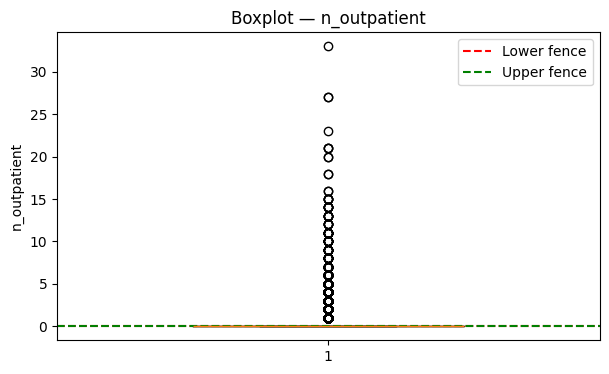

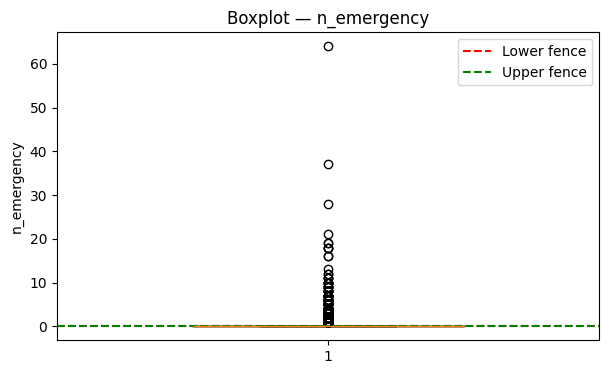

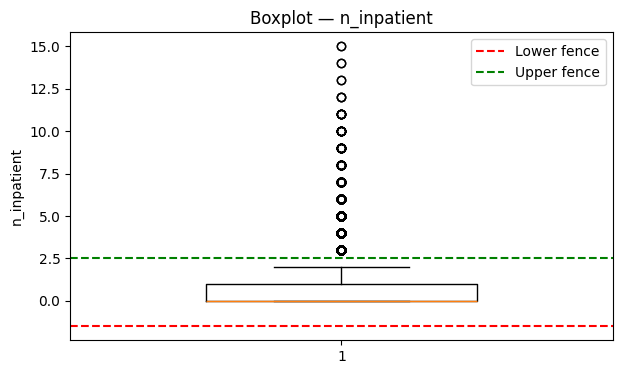

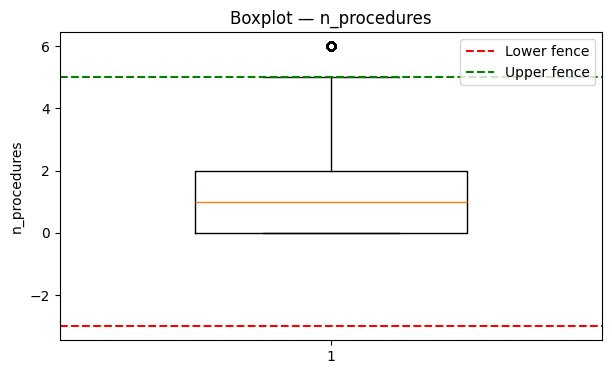

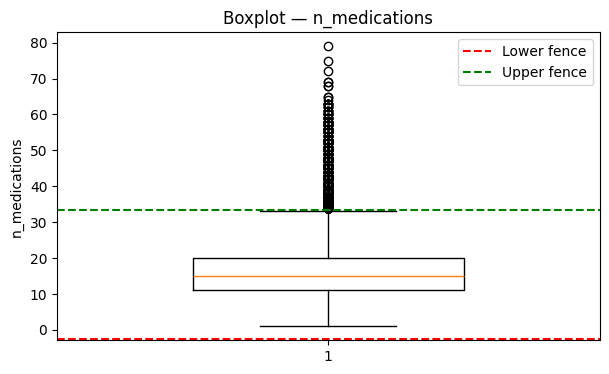

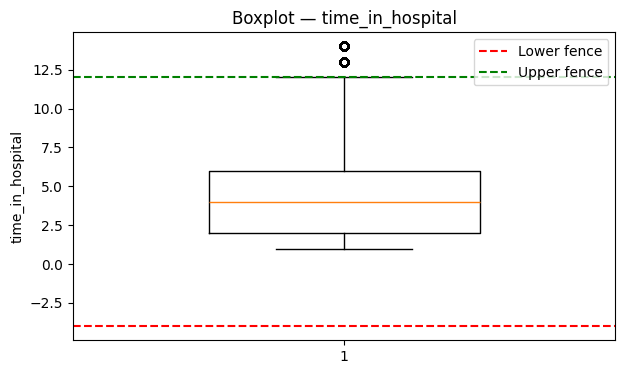

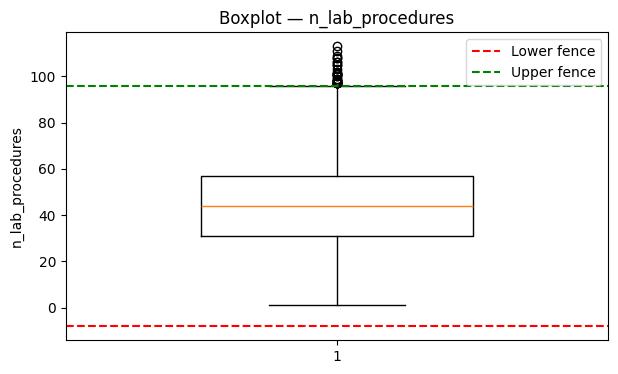

In [16]:
import matplotlib.pyplot as plt

# List of columns with outliers 
cols_with_outliers = [ "n_outpatient", "n_emergency", "n_inpatient",
                        "n_procedures", "n_medications", "time_in_hospital",
                        "n_lab_procedures"]

# 1) I will draw boxplots with outlier fences for the columns that have outliers
for col in cols_with_outliers:
    s = hosp_df[col]      # s for the series of the current column with outliers
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    plt.figure(figsize=(7, 4)) 
    plt.boxplot(s, vert=True, widths=0.5, showfliers=True) 
      # vert=True for vertical boxplot, widths=0.5 for thinner box, showfliers=True to show outliers
    plt.axhline(lower, color='red', linestyle='--', label='Lower fence')     #plt.axhline(lower) to draw horizontal line at lower fence
    plt.axhline(upper, color='green', linestyle='--', label='Upper fence')   #plt.axhline(upper) to draw horizontal line at upper fence
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.legend()
    plt.show()

In [17]:
# 2) I will do quick counts of low and high outliers for the same columns that have outliers
outlier_counts = []
for col in cols_with_outliers:
    s = hosp_df[col]
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_low = (s < lower).sum()
    n_high = (s > upper).sum()
    pct_total = round((n_low + n_high) / len(hosp_df) * 100, 2)  # to calculate percentage of total outliers for each column
    outlier_counts.append([col, n_low, n_high, pct_total])       # to store results of outlier counts

# I will create a DataFrame to display the outlier counts 
import pandas as pd
outlier_counts_df = pd.DataFrame(outlier_counts, columns=["column", "n_low", "n_high", "pct_total"])
outlier_counts_df


,column,n_low,n_high,pct_total
0,n_outpatient,0,4141,16.56
1,n_emergency,0,2728,10.91
2,n_inpatient,0,1628,6.51
3,n_procedures,0,1227,4.91
4,n_medications,0,844,3.38
5,time_in_hospital,0,580,2.32
6,n_lab_procedures,0,33,0.13


-------
### **🧹 Step 2C — Removing Only the Most Extreme Outliers (“Outliers of Outliers”)**

In this step, I carefully reviewed each numeric feature flagged for outliers in **Step 2B** to ensure that only truly extreme, unrepresentative values are removed.

**Approach:**

- **Visual Inspection:** Examined each boxplot to distinguish between naturally high values and truly extreme outliers.
- **Data Review:** Checked the actual data in Excel to see how many rows would be affected at various thresholds.
- **Domain Context:** Consulted the data dictionary to confirm that the values targeted for removal are unrealistic or likely data-entry errors (e.g., an implausibly high number of hospital visits).

**Decision:**  
Rather than removing all statistical outliers, I chose to drop only the most extreme positive “outliers of outliers”—rare values that are highly unlikely in real-world clinical settings. This approach ensures that the dataset remains representative and robust for modeling, while minimizing the risk of skewed results.

**Benefits of This Approach:**

- Improves model reliability by reducing the influence of extreme, unrepresentative cases.
- Maintains the integrity and realism of the dataset by trimming a small percentage (around 1% of rows.)
- Ensures that subsequent analyses (EDA, encoding, modeling) are based on clean, representative data.

**Columns and Thresholds for Outlier Removal:**

| Column            | Description                                 | Threshold for Removal | Rationale                                              |
|-------------------|---------------------------------------------|----------------------|--------------------------------------------------------|
| n_outpatient      | Outpatient visits before hospital stay      | > 25                 | Only 3 rows extremely high; possible data-entry errors |
| n_emergency       | Emergency visits before hospital stay       | > 30                 | Only 2 rows extreme; clearly abnormal                  |
| n_inpatient       | Inpatient visits before hospital stay       | ≥ 12                 | Removes 9 extreme cases; keeps typical range (0–10)    |
| n_procedures      | Procedures during hospital stay             | *Keep as is*         | All values (0–6) are clinically plausible              |
| n_medications     | Medications administered                    | > 60                 | Removes ~22 rare cases; avoids over-trimming           |
| time_in_hospital  | Length of stay (days)                       | > 13                 | 14-day stays (281 rows) are rare but not implausible   |
| n_lab_procedures  | Number of lab procedures                    | > 100                | Only ~16 rows far above typical range                  |

**Summary:**  
By applying these targeted rules, I will remove only the most extreme outliers, preserving the overall structure and validity of the data. The resulting dataset will be saved as a new CSV file and used for all further analysis and modeling.


In [18]:
# Step 2C — I will remove all extreme outliers and save as hosp_df1.csv

# 1. I will only keep rows with realistic values for each column (based on domain knowledge)
#    This helps remove data-entry errors or extremely rare cases that could hurt analysis.

# Firstly, I will define the maximum allowed values for each column (outliers above these will be removed)
max_values = {
    "n_outpatient": 25,        # Remove if outpatient visits > 25
    "n_emergency": 30,         # Remove if emergency visits > 30
    "n_inpatient": 11,         # Remove if inpatient visits >= 12
    "n_medications": 60,       # Remove if medications > 60
    "time_in_hospital": 13,    # Remove if hospital stay > 13 days
    "n_lab_procedures": 100    # Remove if lab procedures > 100
    # n_procedures is not capped (all values are plausible)
}

In [19]:
# 2. I will run a quick check with for loop to see how many rows will be removed for each rule
# For each column in max_values, count how many rows will be removed based on the threshold
for col, cap in max_values.items():
    if col == "n_inpatient":
        # For n_inpatient, remove rows where value is greater than or equal to 12
        n_remove = (hosp_df[col] >= 12).sum()
        print(f"{col}: {n_remove} rows will be removed (>= 12)")
    else:
        # For other columns, remove rows where value is greater than the cap
        n_remove = (hosp_df[col] > cap).sum()
        print(f"{col}: {n_remove} rows will be removed (> {cap})")


n_outpatient: 3 rows will be removed (> 25)
n_emergency: 2 rows will be removed (> 30)
n_inpatient: 9 rows will be removed (>= 12)
n_medications: 22 rows will be removed (> 60)
time_in_hospital: 281 rows will be removed (> 13)
n_lab_procedures: 16 rows will be removed (> 100)


In [20]:
# 3. I will build a mask to keep only rows within the allowed limits for each column as defined in max_values above
mask = (
    (hosp_df["n_outpatient"]     <= 25) &
    (hosp_df["n_emergency"]      <= 30) &
    (hosp_df["n_inpatient"]      <  12) &
    (hosp_df["n_medications"]    <= 60) &
    (hosp_df["time_in_hospital"] <= 13) &
    (hosp_df["n_lab_procedures"] <= 100)
)


In [21]:
#4. Then I will apply the mask to create the cleaned DataFrame as hosp_df1
hosp_df1 = hosp_df[mask].copy()

# I will check how many rows were removed to confirm the cleaning
print(f"\nRows before cleaning: {len(hosp_df)}")
print(f"Rows after cleaning:  {len(hosp_df1)}")
print(f"Rows removed:         {len(hosp_df) - len(hosp_df1)}")


Rows before cleaning: 25000
Rows after cleaning:  24670
Rows removed:         330


In [22]:
#5. I will check summary stats of new min and max for each affected column (to confirm outliers are gone)

cols_to_check = ["n_outpatient", "n_emergency", "n_inpatient", "n_procedures",
                 "n_medications", "time_in_hospital", "n_lab_procedures"]

summary_after = pd.DataFrame({
    "min_after": hosp_df1[cols_to_check].min(),
    "max_after": hosp_df1[cols_to_check].max()
})
print("\nMin/Max after trimming:")
print(summary_after)


Min/Max after trimming:
                  min_after  max_after
n_outpatient              0         23
n_emergency               0         28
n_inpatient               0         11
n_procedures              0          6
n_medications             1         60
time_in_hospital          1         13
n_lab_procedures          1        100


In [23]:

# 6. I will save the cleaned data to a new CSV file for future use
hosp_df1.to_csv("../data/hosp_df1.csv", index=False)
    # I will print confirmation message to ensure saving was successful
print("\nSaved cleaned data to ../data/hosp_df1.csv")


Saved cleaned data to ../data/hosp_df1.csv


#### ✅ Step 2C — Extreme Outlier Removal Complete
**Goal:**  
The primary objective of this step was to remove only the most extreme outliers from the dataset, ensuring that the data remains realistic and is not unduly influenced by rare or highly unusual cases. By carefully trimming these outliers, I improve the quality and reliability of subsequent analyses and modeling.

**What I did:**  
- I thoroughly examined boxplots for each numeric feature and consulted the data dictionary to identify values that were implausibly high or likely due to data entry errors.
- Based on this review, I established clear and transparent rules to drop only the most extreme values from the dataset:
    - Removed rows where `n_outpatient` was greater than 25.
    - Removed rows where `n_emergency` was greater than 30.
    - Removed rows where `n_inpatient` was greater than or equal to 12.
    - Retained all values for `n_procedures`, as the observed range (0–6) was deemed clinically plausible.
    - Removed rows where `n_medications` exceeded 60.
    - Removed rows where `time_in_hospital` was greater than 13 days.
    - Removed rows where `n_lab_procedures` was greater than 100.
- I combined these rules into a single filter and removed any row that violated one or more of these criteria.

**Impact:**  
- The dataset originally contained 25,000 rows.
- After applying the outlier removal rules, 24,670 rows remained.
- A total of 330 rows were removed, representing approximately 1.3% of the dataset.

**New value ranges:**  

| Column             | Min | Max  |
|--------------------|-----|------|
| n_outpatient       | 0   | 23   |
| n_emergency        | 0   | 28   |
| n_inpatient        | 0   | 11   |
| n_procedures       | 0   | 6    |
| n_medications      | 1   | 60   |
| time_in_hospital   | 1   | 13   |
| n_lab_procedures   | 1   | 100  |

These updated ranges confirm that all values now fall within normal, clinically reasonable limits.

**Why this helps:**  
- By removing only the most extreme outliers, the dataset is less likely to produce misleading results or unstable models due to a handful of abnormal cases.
- The data is now easier to analyze and visualize, with distributions that better reflect typical patient experiences.
- The process is fully documented and transparent, making it easy to explain and justify these cleaning decisions in both technical and non-technical settings.

**File saved:**  
The cleaned dataset has been saved as `hosp_df1.csv` and will be used for all subsequent analysis and modeling steps.

**Next:**  
The next phase will involve further exploration of the cleaned data, including examining feature distributions, handling data types, and preparing the dataset for machine learning modeling.



-----
### **📊 Step 2D — Quick Overview of the Cleaned Data**

- Provides a concise summary of the dataset after outlier removal.
- Confirms structure, value ranges, and class balance before further analysis.
- Displays:
    - Number of rows and columns.
    - `describe()` output for numeric columns to verify min/max values align with outlier removal rules.
    - Summary of categorical columns: number of unique values, most common value, and its frequency.
    - Boolean columns (especially the target): True/False counts and percentages to assess class balance.
    - Count of exact duplicate rows (none should remain after cleaning); reports the number found without removing any at this stage.
- Ensures outliers were removed correctly and helps spot potential issues early (e.g., class imbalance or unexpected value ranges).
- Keeps the notebook readable and focused.
- No new features or encoding introduced here—just a simple, clear summary to confirm readiness for next steps.
- Any unusual findings will be noted for follow-up in subsequent steps.

In [24]:
#Step 2D-1: I will set pandas display options to show more rows and columns, making it easier to view the data in the notebook.
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# I will define the file path for the cleaned dataset. 
DATA_PATH = "../data/hosp_df1.csv"

# I will load the cleaned dataset into a pandas DataFrame so we can analyze it.
hosp_df1 = pd.read_csv(DATA_PATH)

# I will display the first few rows of the dataset to quickly check its structure and contents.
hosp_df1.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,unknown,circulatory,respiratory,other,no,no,False,True,False
1,[70-80),3,34,2,13,0,0,0,other,other,other,other,no,no,False,True,False
2,[50-60),5,45,0,18,0,0,0,unknown,circulatory,circulatory,circulatory,no,no,True,True,True
3,[70-80),2,36,0,12,1,0,0,unknown,circulatory,other,diabetes,no,no,True,True,True
4,[60-70),1,42,0,7,0,0,0,internalmedicine,other,circulatory,respiratory,no,no,False,True,False


In [25]:
#Step 2D-2: I will show number of rows and columns

n_rows, n_cols = hosp_df1.shape
print(f"Rows: {n_rows:,} | Columns: {n_cols}")

Rows: 24,670 | Columns: 17


In [26]:
#Step 2D-3: I will select numeric columns and show describe() to check min/max/mean/std/quantiles

# I will find all numeric columns (int or float) and list them
numeric_cols = hosp_df1.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Numeric columns:", numeric_cols)

# 2. I will use describe() to get count, mean, std, min, max, and quartiles for each numeric column
summary = hosp_df1[numeric_cols].describe().T  # .T transposes for easier reading of rows
display(summary)

Numeric columns: ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']


,count,mean,std,min,25%,50%,75%,max
time_in_hospital,24670.0,4.338062,2.834730,1.0,2.0,4.0,6.0,13.0
n_lab_procedures,24670.0,43.011674,19.709992,1.0,31.0,44.0,57.0,100.0
n_procedures,24670.0,1.334739,1.702220,0.0,0.0,1.0,2.0,6.0
n_medications,24670.0,16.098338,7.840539,1.0,11.0,15.0,20.0,60.0
n_outpatient,24670.0,0.363397,1.155563,0.0,0.0,0.0,0.0,23.0
n_inpatient,24670.0,0.609404,1.150907,0.0,0.0,0.0,1.0,11.0
n_emergency,24670.0,0.183259,0.754155,0.0,0.0,0.0,0.0,28.0


In [27]:
# Step 2D-4: I will create a compact summary for categorical columns (object/category)

# I will find all categorical columns (object or category type) to summarize them 
cat_cols = hosp_df1.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", cat_cols)

# For each categorical column, I will use for loop to show non-null count, unique values, most common value and its count
summary_rows = []
for col in cat_cols:
    s = hosp_df1[col]
    non_null = s.notna().sum()
    n_unique = s.nunique(dropna=True)
    # I will find the most common value and its count
    if non_null > 0:
        top_val = s.mode(dropna=True)
        if not top_val.empty:
            top_val = top_val.iloc[0]
            top_count = (s == top_val).sum()
        else:
            top_val = None
            top_count = 0
    else:
        top_val = None
        top_count = 0
    summary_rows.append({
        "column": col,
        "non_null": non_null,
        "n_unique": n_unique,
        "top_value": top_val,
        "top_count": top_count
    })

cat_summary = pd.DataFrame(summary_rows).sort_values("n_unique", ascending=False).reset_index(drop=True)
display(cat_summary)

Categorical columns: ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest']


,column,non_null,n_unique,top_value,top_count
0,diag_1,24670,8,circulatory,7724
1,diag_3,24670,8,other,8988
2,diag_2,24670,8,other,8931
3,medical_specialty,24670,7,unknown,12227
4,age,24670,6,[70-80),6761
5,glucose_test,24670,3,no,23303
6,A1Ctest,24670,3,no,20688


In [28]:
# Step 2D-5: I will summarize boolean columns (True count, False count, and % True)

# Find boolean columns
bool_cols = hosp_df1.select_dtypes(include="bool").columns.tolist()
print("Boolean columns:", bool_cols)

# Summarize True/False counts and % True for each boolean column
summary = []
for col in bool_cols:
    n_true = hosp_df1[col].sum()
    n_false = (~hosp_df1[col]).sum()
    total = n_true + n_false
    pct_true = (n_true / total * 100) if total > 0 else 0
    pct_false = (n_false / total * 100) if total > 0 else 0
    summary.append({
        "column": col,
        "n_true": n_true,
        "n_false": n_false,
        "pct_true": round(pct_true, 2),
        "pct_false": round(pct_false, 2)
    })

pd.DataFrame(summary)

Boolean columns: ['change', 'diabetes_med', 'readmitted']


,column,n_true,n_false,pct_true,pct_false
0,change,11307,13363,45.83,54.17
1,diabetes_med,18953,5717,76.83,23.17
2,readmitted,11596,13074,47.00,53.00


In [29]:
# Step 2D-6: I will count exact duplicate rows (after outlier removal, this should be zero)
# Note: I will not drop them here; I only report the number.

n_dupes = hosp_df1.duplicated().sum()
print(f"Duplicate rows (exact): {n_dupes}")


Duplicate rows (exact): 0


#### 📝 **Summary Report & Key Findings After Data Cleaning (Step 2D)**

After comprehensive data cleaning, the dataset is now well-structured and ready for modeling. Key outcomes from Step 2D:

**1. Dataset Structure**
- **Rows:** 24,670  **Columns:** 17
- Only ~1.3% of rows were removed due to extreme outliers.

 **2. Numeric Features**
- All numeric columns have plausible value ranges and no missing values.
- Descriptive stats confirm min/max values are clinically reasonable.

 **3. Categorical Features**
- All categorical columns are free of ambiguous or placeholder values.
- Most common values and unique counts confirm data consistency.

 **4. Boolean Features**
- Binary columns (`change`, `diabetes_med`, `readmitted`) are standardized to Boolean.
- Target (`readmitted`) is reasonably balanced:  
    - **True:** 11,596 (47.0%)  
    - **False:** 13,074 (53.0%)

 **5. Duplicates**
- **Exact duplicate rows:** 0

 **6. Missing Values**
- No missing (NaN) values remain; all placeholders have been standardized.

 **7. Outliers**
- Only the most extreme outliers were removed; all numeric features now fall within realistic ranges.

**🧩 Target & Integrity Check**

- Target (readmitted) confirmed as Boolean (True / False).
- Class balance: 11,596 (47%) True | 13,074 (53%) False.
- Duplicates: None detected (0 rows).
- Data leakage: No identical or proxy columns found at this stage — a final check will be done before modeling.


----
### **🧭 Step 2E — Exploratory Data Analysis (EDA)**

**Goal**  
Visually explore how the target variable (`readmitted`) behaves across key features to inform decisions on which variables to keep, group, engineer, or drop before encoding.

**What I’ll Do (Steps 2E-1 → 2E-6):**

**2E-1 — Setup**  
- Load the cleaned dataset (`df = hosp_df1`)
- Set plotting defaults
- Ensure `readmitted` is Boolean
- Define column lists for analysis

**2E-2 — Target Overview**  
- Bar chart of overall readmission distribution (counts and % labels) to check class balance

**2E-3 — Categorical vs Target**  
- For `medical_specialty`, `diag_1`, `diag_2`, `diag_3`:  
    - Plot bar (count) + line (readmit rate %) on a dual axis (Plotly)
    - Always include the "unknown" group for transparency

**2E-4 — Numeric vs Target**  
- For numeric features (`time_in_hospital`, `n_lab_procedures`, `n_procedures`, `n_medications`, `n_outpatient`, `n_inpatient`, `n_emergency`):  
    - Grouped histograms (side-by-side by `readmitted`) to compare distributions and spot trends  

**2E-5 — Additional Categorical vs Target**  
- For `age`, `glucose_test`, `A1Ctest`, `change`, `diabetes_med`:  
    - Same bar + line approach  
    - Add a brief quick-analysis under each chart to guide feature engineering

**2E-6 — Simple Feature Flags**  
- Engineer binary flags for test status/results: `glucose_done`, `glucose_high`, `A1C_done`, `A1C_high`

**Decision Flow (applied after each group, summarized at end):**
- Keep features with clear separation or clinical value
- Group high-cardinality categories (e.g., Top-N + “Other”)
- Drop noisy, sparse, or low-signal fields
- Engineer simple, interpretable flags where categories can be simplified

**Outputs:**  
- 1 target chart  
- 4 categorical feature charts  
- 7 numeric feature charts  
- 5 additional categorical charts  
- Each chart includes a short note  
- Finish with a Step 2E Decision Summary and column drop recommendations

---

#### Step 2E-1: Setup (imports, helpers, and column lists)

In [30]:
import matplotlib.pyplot as plt

# Use the cleaned DataFrame for EDA
df = hosp_df1

# Set simple plot style
plt.rcParams["figure.figsize"] = (9, 5)     #plt.rcParams["figure.figsize"] to set default figure size
plt.rcParams["axes.grid"] = True            #plt.rcParams["axes.grid"] to enable grid on plots


# Make sure the target is boolean (should already be, but just in case)
df["readmitted"] = df["readmitted"].astype(bool)     #astype(bool) to ensure readmitted is boolean type

# List categorical columns to scan
cat_cols_2E = ["medical_specialty", "diag_1", "diag_2", "diag_3"]

# List numeric columns to scan (exclude booleans and id if present)
num_cols_2E = [col for col in df.select_dtypes(include="number").columns
               if col not in ["readmitted", "change", "diabetes_med"]]

print("Categorical to scan:", cat_cols_2E)
print("Numeric to scan:", num_cols_2E)


Categorical to scan: ['medical_specialty', 'diag_1', 'diag_2', 'diag_3']
Numeric to scan: ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']


-----
#### Step 2E-2: Target overview (counts + %) 

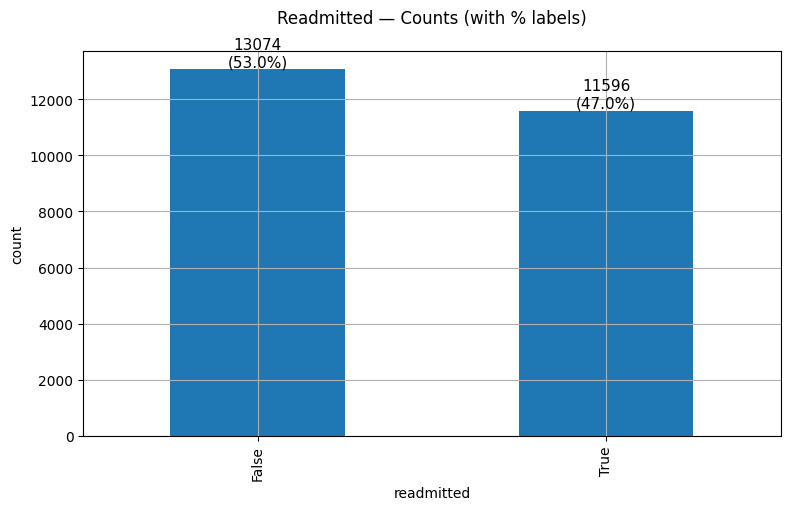

            count   pct
readmitted             
False       13074  53.0
True        11596  47.0


In [31]:
# I will show a simple bar chart for readmitted distribution (counts + percentages)
counts = df["readmitted"].value_counts().sort_index()
perc = (counts / counts.sum() * 100).round(1)     # counts / counts.sum() * 100 to calculate percentage for each class

ax = counts.plot(kind="bar")                                 # ax is the axes object for further customization
ax.set_title("Readmitted — Counts (with % labels)", pad=20)
ax.set_xlabel("readmitted")
ax.set_ylabel("count")

for i, v in enumerate(counts.values):                  # i for index, v for value   #enumerate(counts.values) to loop through counts 
    ax.text(i, v, f"{v}\n({perc.values[i]}%)", ha="center", va="bottom", fontsize=11, color="black")  
                            # perc.values[i] to get percentage for each bar,
                            # ha="center" to center text horizontally, va="bottom" to place text above bar
plt.show()

print(pd.DataFrame({"count": counts, "pct": perc}))

🔍 **Quick Analysis — Target Overview (`readmitted`)**

- **Class Balance:**  
    - 53% not readmitted  
    - 47% readmitted  
    - Nearly even split between classes

- **Implications:**  
    - No need for resampling; both classes have sufficient observations
    - Model evaluation metrics (accuracy, F1-score) will be meaningful and reliable

- **Next Steps:**  
    - Explore how each feature relates to the target variable in the following sections

    ---

#### Step 2E-3: Categorical vs target plots (bar + line) using Plotly for interactivity and better aesthetics

In [32]:
# I will define a function to plot categorical column vs readmitted target using Plotly 
# The function will create a bar plot for counts and a line plot for readmission rate (%) on a secondary y-axis
# It will also display a summary table below the plot for reference

import plotly.graph_objects as go

# I will define the function to create the plot and summary table 
def plot_cat_vs_target_plotly(df, col, min_count=200, top_n=20):   
      # I will prepare summary data for the plot 
    value_counts = df[col].value_counts()
    value_counts = value_counts[value_counts >= min_count]   # Filter categories with at least min_count occurrences for reliability
    top_categories = value_counts.index[:top_n]              # Select top_n categories by count for plotting to enhance readability
    summary = pd.DataFrame({
        "count": value_counts.loc[top_categories]            # .loc[top_categories] to get counts for top categories only
    })
    readmit_rates = df[df[col].isin(top_categories)].groupby(col)["readmitted"].mean() * 100    
       # Group by col and calculate mean readmission rate (%) for top categories only 
    summary["readmit_rate_pct"] = readmit_rates.round(1)
    summary = summary.loc[top_categories]                    # summary.loc to ensure order matches top categories

    # Plotly figure
    fig = go.Figure()

    # I will create bar chart for counts to the left y-axis
    fig.add_trace(go.Bar(
        x=summary.index,
        y=summary["count"],
        name="Count",
        marker_color="skyblue",
        text=summary["count"],
        textposition="auto",         # textposition="auto" to automatically position text on bars 
        textfont=dict(size=12),
        yaxis="y1"                   # yaxis="y1" to link to left y-axis
    ))

    # I will create line chart for readmission rate (%) to the right y-axis
    fig.add_trace(go.Scatter(         # create a scatter trace for line plot
        x=summary.index,
        y=summary["readmit_rate_pct"],
        name="Readmit Rate (%)",
        mode="lines+markers+text",
        marker=dict(color="red", size=10), 
        line=dict(width=2),
        text=[f"{v}%" for v in summary["readmit_rate_pct"]],
        textposition="top center",
        textfont=dict(size=10, color="navy"),  # I will set smaller font size for better visibility of line labels
        yaxis="y2"
    ))


    # I will update layout for dual y-axes and better aesthetics
    fig.update_layout(
        title=f"{col} — Group Size & Readmission Rate (%)",
        xaxis=dict(title=col, tickangle=55, tickfont=dict(size=13)),         # tickangle=55 to rotate x-axis labels for better readability
        yaxis=dict(title="Count", showgrid=True, tickfont=dict(size=13)),    # set tickfont size for left y-axis
        yaxis2=dict(
            title="Readmission Rate (%)",
            overlaying="y",                                                 # overlaying="y" to overlay on left y-axis for dual axis
            side="right",                                                   # side="right" to place right y-axis on the right side 
            showgrid=False,
            range=[0, max(100, summary["readmit_rate_pct"].max()*1.15)],    # set range to max of 100 or 15% above max rate for better visibility
            tickfont=dict(size=13)
        ),
        legend=dict(
            x=1.02, y=1, xanchor="left", yanchor="top",                    # xanchor and yanchor to position legend outside plot area
            bgcolor='rgba(255,255,255,0.7)',                               # rgba(255,255,255,0.7) for semi-transparent background which improves readability
            bordercolor="black",                                           # bordercolor="black" to add border around legend for separation
            borderwidth=1,
            font=dict(size=13)
        ),
        bargap=0.25,
        height=650,
        width=1200,
        margin=dict(l=60, r=180, t=60, b=200)                             # margin=dict to add space for rotated x-axis labels for better readability
    )

    fig.show()
    display(summary.sort_values(["readmit_rate_pct", "count"], ascending=[False, False]).head(10))

# I will loop through each categorical column and generate the plots for analysis
for c in cat_cols_2E:
    print(f"\n=== {c} ===")
    plot_cat_vs_target_plotly(df, c, min_count=100, top_n=20)    # min_count=100 to include categories with at least 100 occurrences, top_n=20 to show top 20 categories



=== medical_specialty ===


,count,readmit_rate_pct
medical_specialty,,
family/generalpractice,1861,49.6
emergency/trauma,1862,49.5
unknown,12227,48.9
internalmedicine,3511,44.8
cardiology,1398,44.8
other,2623,41.3
surgery,1188,41.1



=== diag_1 ===


,count,readmit_rate_pct
diag_1,,
diabetes,1730,53.6
respiratory,3634,48.9
circulatory,7724,48.0
digestive,2309,47.3
other,6376,45.1
injury,1646,43.6
musculoskeletal,1247,39.5



=== diag_2 ===


,count,readmit_rate_pct
diag_2,,
respiratory,2827,48.9
circulatory,8034,48.3
other,8931,47.0
musculoskeletal,418,46.2
diabetes,2887,44.0
digestive,958,43.8
injury,573,40.7



=== diag_3 ===


,count,readmit_rate_pct
diag_3,,
respiratory,1888,49.9
circulatory,7575,48.3
digestive,903,47.1
other,8988,46.8
diabetes,4219,45.5
musculoskeletal,447,45.0
injury,454,42.7
unknown,196,28.6


📊 **Quick Analysis — Categorical Features vs Target (`readmitted`)**

**medical_specialty**  
A large proportion of records are labeled as “unknown,” which dominates the category counts. The readmission rate for “unknown” is close to the overall average, suggesting limited predictive value on its own.

*Action (tentative):* Retain for now, but group into Top-N most frequent specialties plus an “Other/Unknown” category to reduce sparsity. Consider dropping if it shows little signal after encoding.

**diag_1 (Primary Diagnosis)**  
This feature shows clear variation in readmission rates across categories (e.g., diabetes ≈ 53–54% vs musculoskeletal ≈ 39–41%), indicating strong predictive potential.

*Action:* Keep. Use Top-N most common diagnoses plus “Other/Unknown” to manage cardinality.

**diag_2 & diag_3 (Secondary Diagnoses)**  
These features display moderate variation in readmission rates, with long tails and a significant share of “other/unknown” values.

*Action:* Provisionally keep, but collapse into Top-N plus “Other/Unknown” to reduce noise. If their contribution is minimal after encoding, consider dropping one to simplify the model.

**General Notes**  
- Throughout the analysis, “unknown” is always treated as an explicit category rather than as missing data.
- The number of categories per feature is limited (e.g., top 6–10) before one-hot encoding, to reduce sparsity and improve model performance.

---


#### Step 2E-4: Numeric vs target plots (histograms) using Plotly for interactivity and better aesthetics

In [33]:
# I will define a function to plot numeric column vs readmitted target using Plotly 
# The function will create a grouped histogram to compare distributions for readmitted vs not readmitted
# It will also display counts on top of bars for clarity 

import plotly.express as px

# I will define the function to create the grouped histogram 
def plot_num_vs_readmitted_plotly(df, col):
    fig = px.histogram(
        df, x=col, color="readmitted",                           # color="readmitted" to color bars by readmitted status
        barmode="group",                                         # barmode="group" to place bars side by side for comparison
        nbins=30,                                                # nbins=30 to set number of bins for histogram
        color_discrete_map={True: "tomato", False: "steelblue"},  # custom colors for better visibility 
        labels={"readmitted": "Readmitted"},
        category_orders={"readmitted": [False, True]}
    )
    fig.update_traces(texttemplate='%{y}', textposition='inside', marker_line_width=1)    
            # texttemplate='%{y}' to show counts on top of bars, textposition='inside' to position text inside bars
    fig.update_layout(
        title=f"{col} distribution by Readmitted status",
        xaxis_title=col,
        yaxis_title="Count",
        legend_title="Readmitted",
        bargap=0.15,                             # bargap=0.15 to add space between bars for better readability
        uniformtext_minsize=8,
        uniformtext_mode='hide'                   # uniformtext_mode='hide' to hide text if it doesn't fit
    )
    fig.show()

# I will loop through each numeric column and generate the plots for analysis 
for c in num_cols_2E:
    print(f"\n=== {c} ===")
    plot_num_vs_readmitted_plotly(df, c)


=== time_in_hospital ===



=== n_lab_procedures ===



=== n_procedures ===



=== n_medications ===



=== n_outpatient ===



=== n_inpatient ===



=== n_emergency ===


🔢 **Quick Analysis — Numeric Features vs Target (`readmitted`)**

Based on my own EDA, here’s how each numeric feature relates to readmission, with notes on next steps:

**time_in_hospital**  
- Slight increase in readmission rate for stays around 6–8 days; otherwise, rates are close to baseline.
- **Action:** Keep. Consider binning (e.g., 1–3, 4–6, 7–9, 10+) to reduce noise.

**n_lab_procedures**  
- Distribution is broad and roughly bell-shaped (peak ~40–60). Readmission rates are similar across most values, with a mild uptick at higher counts.
- **Action:** Keep. May standardize or bin into quantiles.

**n_procedures**  
- Most values are 0–2; little separation by target.
- **Action:** Keep for now. Treat as categorical bins (0, 1, 2, 3+) to avoid sparse numeric effects.

**n_medications**  
- Right-skewed; readmission rate rises modestly with higher medication counts (up to ~20–25).
- **Action:** Keep. Consider clipping the long tail (e.g., at 95th percentile) and/or binning.

**n_outpatient (prior year)**  
- Extremely right-skewed; most patients have 0 visits, with very few high counts. Slight positive trend with more visits.
- **Action:** Keep (potential signal). Cap at 3–5 and encode as 0, 1, 2, 3+.

**n_inpatient (prior year)**  
- Strong monotonic pattern: more prior inpatient visits clearly relate to higher readmission risk.
- **Action:** Keep (strong signal). Cap at 3+ and treat as ordered bins.

**n_emergency (prior year)**  
- Similar to outpatient: heavily concentrated at 0, with a slight increase in readmission for higher counts.
- **Action:** Keep. Cap at 5+ and bin as 0, 1, 2, 3–4, 5+.

**General Notes:**  
- Most numeric features are skewed; binning/capping will help stabilize variance and reduce outlier influence.
- No evidence of data leakage; all features reflect information available at admission.
- I will reassess feature importance after encoding and drop low-value features if needed.

---




#### Step 2E-5: Additional categorical vs target plots (bar + line) using Plotly for interactivity and better aesthetics

In [34]:
# I will import necessary libraries and define a function to plot categorical column vs readmitted target using Plotly
# The function will create a bar plot for counts and a line plot for readmission rate (%) on a secondary y-axis

import plotly.graph_objects as go

# I will define age order for better visualization
age_order = [
    "[0-10)", "[10-20)", "[20-30)", "[30-40)", "[40-50)",
    "[50-60)", "[60-70)", "[70-80)", "[80-90)", "[90-100)"
]  

# I will define the function to create the plot and summary table for categorical vs target
def plot_cat_vs_target_simple(df, col, category_order=None):
    vc = df[col].value_counts()                                                                          # vc for value counts of the column
    idx = category_order if category_order else vc.index                                                 # idx for index order (custom or default)
    summary = pd.DataFrame({"count": vc.loc[[c for c in idx if c in vc.index]]})
    summary["readmit_rate_pct"] = df.groupby(col)["readmitted"].mean().loc[summary.index] * 100         # to calculate readmission rate (%) for each category 
    summary["readmit_rate_pct"] = summary["readmit_rate_pct"].round(1)                                  # to round readmission rate to 1 decimal place


      # I will create Plotly bar + line plot for counts and readmission rate (%) 
    fig = go.Figure([
        go.Bar(x=summary.index, y=summary["count"], name="Count", marker_color="skyblue", text=summary["count"], textposition="outside", yaxis="y1"),
        go.Scatter(x=summary.index, y=summary["readmit_rate_pct"], name="Readmit Rate (%)", mode="lines+markers+text",
                   marker=dict(color="red", size=12), line=dict(width=2),
                   text=[f"{v}%" for v in summary["readmit_rate_pct"]], textposition="top center", yaxis="y2")
    ])

    # I will update layout for dual y-axes and better aesthetics 
    fig.update_layout(
        title=f"{col} — Count and Readmission Rate (%)",
        xaxis=dict(title=col, tickangle=45),                                           # tickangle=45 to rotate x-axis labels for better readability
        yaxis=dict(title="Count"),
        yaxis2=dict(title="Readmission Rate (%)", overlaying="y", side="right",
                    range=[0, max(100, summary["readmit_rate_pct"].max() * 1.15)]),     # to set range to max of 100 or 15% above max rate for better visibility
        legend=dict(x=1.02, y=1, xanchor="left", yanchor="top",                         # xanchor and yanchor to position legend outside plot area for better readability
                    bgcolor='rgba(255,255,255,0.7)', bordercolor="green", borderwidth=1),   # to style legend with semi-transparent background and border for separation
        bargap=0.25, height=600, width=1100
    )
    fig.show()
    display(summary)

# I will add printed section headers and generate plots for specific categorical columns
print("\n--- age ---")
plot_cat_vs_target_simple(df, "age", category_order=age_order)

for c in ["glucose_test", "A1Ctest"]:
    print(f"\n--- {c} ---")
    plot_cat_vs_target_simple(df, c)

for c in ["change", "diabetes_med"]:
    print(f"\n--- {c} ---")
    plot_cat_vs_target_simple(df.assign(**{c: df[c].astype(str)}), c, category_order=["False", "True"])  
     # df.assign(**{c: df[c].astype(str)}) to convert boolean to string for better x-axis labels
     # category_order=["False", "True"] to set custom order for boolean categories



--- age ---


,count,readmit_rate_pct
age,,
[40-50),2505,44.6
[50-60),4396,44.0
[60-70),5826,46.7
[70-80),6761,48.8
[80-90),4439,49.8
[90-100),743,42.3



--- glucose_test ---


,count,readmit_rate_pct
glucose_test,,
no,23303,46.8
normal,686,48.3
high,681,52.0



--- A1Ctest ---


,count,readmit_rate_pct
A1Ctest,,
no,20688,47.5
high,2764,45.8
normal,1218,42.2



--- change ---


,count,readmit_rate_pct
change,,
False,13363,45.0
True,11307,49.3



--- diabetes_med ---


,count,readmit_rate_pct
diabetes_med,,
False,5717,41.4
True,18953,48.7


🧩 **Step 2E-5 — Quick Analysis: Additional Categorical vs Target (5 charts)**

**Overview:**  
This section summarizes key findings from five categorical features, highlighting how patient characteristics and diabetes-related test results relate to readmission risk. These insights will guide feature engineering and model design.


**age:**  
- Readmission rates are relatively stable across age groups (~42–50%), with only a slight decrease in the oldest group.
- **Interpretation:** Age alone does not strongly predict readmission, but its ordered nature may interact with other risk factors.
- **Action:** Keep as an ordered categorical feature for potential interaction effects.

**glucose_test:**  
- Patients with a “high” glucose test result have a noticeably higher readmission rate (~52%) compared to those with “normal” or “no” test.
- **Interpretation:** High glucose is a clear clinical risk factor for readmission.
- **Action:** Engineer a binary “high glucose” flag in the next step to capture this effect.

**A1Ctest:**  
- A similar pattern is observed: “high” A1C levels are associated with increased readmission risk.
- **Interpretation:** High A1C is a strong indicator of poor diabetes control and higher risk.
- **Action:** Create a binary “high A1C” flag for modeling.

**change:**  
- Patients who had a medication change during their stay show a slightly higher readmission rate (~49% vs 45%).
- **Interpretation:** Medication changes may reflect more complex or unstable cases.
- **Action:** Keep this feature to track care adjustments.

**diabetes_med:**  
- Patients on diabetes medication have a higher readmission rate (~49%) than those not on medication (~41%).
- **Interpretation:** Being on medication likely signals more severe or poorly controlled diabetes.
- **Action:** Retain as a key indicator of disease severity.

**Next Step (Step 2E-6):**  
Engineer simple binary flags for “high” glucose and A1C results to capture these medical threshold effects and simplify encoding. The original columns will be retained for comparison during feature selection and model evaluation.

----

#### Step 2E-6: Engineer new features (simple flags) for glucose and A1C tests

In [35]:
# I will create new columns to indicate if a glucose or A1C test was performed, and if the result was "high".
# This helps make the data easier to use for modeling and interpretation.

# 1. I will standardize the text in the test columns to lowercase and remove extra spaces for consistency.
df["glucose_test"] = df["glucose_test"].astype(str).str.strip().str.lower()
df["A1Ctest"]      = df["A1Ctest"].astype(str).str.strip().str.lower()

# 2. I will define a set of values that mean the test was not performed or is missing.
not_done = {"no", "none", "not performed", "na", "n/a", "unknown", ""}

# 3. I will create a flag column for each test:
#    - "glucose_done" and "A1C_done" will be 1 if the test was performed, 0 if not.
#    - "glucose_high" and "A1C_high" will be 1 if the result was "high", 0 otherwise.
df["glucose_done"] = (~df["glucose_test"].isin(not_done)).astype(int)
df["glucose_high"] = (df["glucose_test"] == "high").astype(int)

df["A1C_done"] = (~df["A1Ctest"].isin(not_done)).astype(int)
df["A1C_high"] = (df["A1Ctest"] == "high").astype(int)

# 4. I will display the first few rows of the new columns to check that the flags were created correctly.
df[["glucose_test", "glucose_done", "glucose_high", "A1Ctest", "A1C_done", "A1C_high"]].head()

,glucose_test,glucose_done,glucose_high,A1Ctest,A1C_done,A1C_high
0,no,0,0,no,0,0
1,no,0,0,no,0,0
2,no,0,0,no,0,0
3,no,0,0,no,0,0
4,no,0,0,no,0,0


🔧 **Step 2E-6 — Quick Analysis: Engineered Flags for Glucose & A1C**

**Summary of Actions**

- Standardized `glucose_test` and `A1Ctest` values (converted to lowercase, removed extra spaces).
- Created four binary indicator columns:
    - `glucose_done`: 1 if a glucose test was performed (not “no”, “none”, “not performed”, “na”, “unknown”); else 0.
    - `glucose_high`: 1 if the glucose test result was “high”; else 0.
    - `A1C_done`: 1 if an A1C test was performed; else 0.
    - `A1C_high`: 1 if the A1C test result was “high”; else 0.

**Benefits**

- Simplifies categorical test results into clear, interpretable 0/1 features.
- Separates the presence of testing from the clinical severity (“high” result).
- Explicitly encodes “no test” as `done=0`, `high=0`, making these cases easy for models to learn from.

**Sanity Checks**

- “High” results are much less frequent than “no” or “normal”, as expected.
- No data leakage: all engineered flags use only information available at discharge.

**Key Insights**

- Patients with “high” glucose or A1C results show higher readmission rates.
- Differences between “test done” and “not done” groups suggest workflow or context signals that may be useful for modeling.

**Next Steps**

- Retain these four engineered flags for modeling.
- No further one-hot encoding needed; these are already numeric features.
- Proceed to the final Step 2E decision summary and drop any columns deemed unnecessary.

---

#### 🧮 **Step 2E-7 — Feature Selection Decision Summary**

**🎯 Target Variable:**  
- `readmitted` (this is what I want to predict)

✅ **Features to Keep (Useful for Prediction or Business Needs)**

**Categorical:**
- `medical_specialty` (keep, but later group into Top-N most common plus "Other" for modeling)
- `diag_1`, `diag_2`, `diag_3` (keep, since different values show different readmission rates)
- `age` (keep, shows a small but steady pattern; easy to use)
- `change`, `diabetes_med` (keep, both are linked to higher readmission when True)

**Numeric:**
- `time_in_hospital` (keep, slightly higher for readmitted patients)
- `n_lab_procedures` (keep, shows some difference)
- `n_medications` (keep, clear difference in the middle values)
- `n_inpatient`, `n_emergency` (keep, even though skewed, they show differences for readmitted patients)

 🛠️ **Features to Create (Use Flags, Remove Raw Columns)**

- **Keep:** `glucose_done`, `glucose_high`, `A1C_done`, `A1C_high` (these new columns were created in Step 2E-6)
- **Drop:** The original `glucose_test` and `A1Ctest` columns (the new flags have the important info and are easier to use)

🚫 **Features to Drop (Not Useful or Repeated Info)**

- `n_outpatient` — mostly zeros, doesn’t help predict readmission
- `n_procedures` — mostly 0 or 1, not much difference between groups, overlaps with lab/procedure intensity already captured by n_lab_procedures/n_medications.

📝 **Summary**

- This is not my final feature list, but a working set based on current EDA and interpretability.
- The result is a simpler, more interpretable feature set with less noise and easier one-hot encoding later.
- I will revisit and refine this list after further feature engineering and model evaluation.

In [36]:
# Step 2E-7: Apply final keep/drop decisions (beginner-friendly)

# I will make a copy of the cleaned dataset
df = hosp_df1.copy()

# I will list the columns to drop based on prior analysis 
drop_cols = [
    "glucose_test",   # replaced by glucose_done and glucose_high 
    "A1Ctest",        # replaced by A1C_done and A1C_high
    "n_outpatient",   # low signal, many outliers with heavily zero-inflated distribution
    "n_procedures"    # low separation, overlaps conceptually with other procedure/medication counts
]

# I will run for loop to drop the unwanted columns if they exist in the DataFrame
for col in drop_cols:
    if col in df.columns:
        df = df.drop(col, axis=1)

# I will print which columns were dropped for confirmation 
print("Dropped columns:", [col for col in drop_cols if col in hosp_df1.columns])

# I will show an example of key columns that were kept and the new shape of the DataFrame
kept_example = [
    "readmitted", "medical_specialty", "diag_1", "diag_2", "diag_3", "age",
    "change", "diabetes_med", "glucose_done", "glucose_high", "A1C_done", "A1C_high",
    "time_in_hospital", "n_lab_procedures", "n_medications", "n_inpatient", "n_emergency"
]
print("Example of key columns kept:")
print([col for col in kept_example if col in df.columns])
print(f"New DataFrame shape: {df.shape[0]} rows × {df.shape[1]} columns")

# Save the new DataFrame for the next step
hosp_df2 = df.copy()

# save the new DataFrame to a CSV file for future use
hosp_df2.to_csv("../data/hosp_df2.csv", index=False)

Dropped columns: ['glucose_test', 'A1Ctest', 'n_outpatient', 'n_procedures']
Example of key columns kept:
['readmitted', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'age', 'change', 'diabetes_med', 'glucose_done', 'glucose_high', 'A1C_done', 'A1C_high', 'time_in_hospital', 'n_lab_procedures', 'n_medications', 'n_inpatient', 'n_emergency']
New DataFrame shape: 24670 rows × 17 columns


#### ✅ **Step 2E-7 — Post-Decision Summary (Features Kept, Engineered, and Dropped)**

**Target:**  
- `readmitted` (balanced: ~53% not readmitted, 47% readmitted, see Step 2E-2)

**Features Kept (Predictive/Business Signal):**

- **Categorical:**  
    - `medical_specialty`, `diag_1`, `diag_2`, `diag_3`, `age`, `change`, `diabetes_med`  
    - *Reason:* These show clear differences in readmission rates or have strong clinical relevance. I will group categories and one-hot encode them in later steps.

- **Numeric:**  
    - `time_in_hospital`, `n_lab_procedures`, `n_medications`, `n_inpatient`, `n_emergency`  
    - *Reason:* Histograms showed meaningful distribution shifts by readmission status, especially for lab, medication, and utilization counts.

**Engineered Features (Binary Flags from Step 2E-6):**

- `glucose_done`, `glucose_high`, `A1C_done`, `A1C_high`  
    - *Reason:* These replace uneven 3-level test results with robust, interpretable indicators for "test performed" and "high" result.

**Features Dropped (Low or Duplicative Signal):**

- `glucose_test`, `A1Ctest` → replaced by the engineered flags above.
- `n_outpatient` → extremely skewed, minimal separation by target.
- `n_procedures` → mostly 0/1, limited incremental value given other procedure/medication features.

**Sanity Checks & Notes:**

- No evidence of target leakage in the kept features; all reflect information available at or before discharge.
- High-cardinality categorical columns (e.g., `medical_specialty`) will be grouped into Top-N plus "Other" before encoding.
- The current working dataset is saved as `hosp_df2.csv` with 17 columns for the next stage.


**Next Steps:**

- Group categories (Top-N + "Other") for `medical_specialty` and diagnosis fields as needed.
- One-hot encode categorical features, including the engineered flags.
- Run a quick correlation and redundancy check after encoding; consider simple scaling for numeric features if required by the model.
- Perform train/validation split and build baseline models.

------

### **📊 Step 3 — Feature Encoding, Correlation Analysis & Dataset Preparation**

**Goal:**  
Transform the cleaned dataset (`hosp_df2`) into a modeling-ready format by encoding categorical variables, exploring feature correlations, and finalizing the dataset for modeling.

**Step Overview:**  
- **Step 3A:** One-Hot Encode all relevant categorical features as planned, ensuring compatibility with machine learning models.
- **Step 3B:** Explore feature correlations by generating a correlation matrix heatmap.  
    - Export the correlation matrix to `corr_matrix.csv` for deeper inspection.
    - Optionally drop highly correlated or redundant features to reduce multicollinearity.
- **Step 3C:** Combine the encoded categorical features with numeric and engineered binary variables, and save the finalized modeling dataset as `hosp_df3.csv`.

**Output:**  
- A fully processed, machine-learning-friendly dataset ready for train/validation split and baseline model development.
- Correlation matrix file for further analysis and documentation.

This workflow ensures all features are consistently encoded, highly correlated variables are identified, and the final dataset is robust and interpretable for modeling.

---

#### **🏷️ Step 3A — Finalize Categorical Encoding Plan**

**Goal**  
Establish a clear, reproducible encoding strategy for categorical features to ensure a smooth transition into model development.

**Approach**

- **Review Cardinality:**  
    - Key categorical features: `medical_specialty`, `diag_1`, `diag_2`, `diag_3`, `age`, `change`, `diabetes_med`.
    - Each feature has a manageable number of categories (typically 6–8, as established in Step 2E).
    - The "unknown" category is retained as a distinct, interpretable level.

- **Grouping Decision:**  
    - No further grouping is required at this stage, as categories are already compact and meaningful.

- **Encoding Method:**  
    - Apply **One-Hot Encoding (OHE)** to all categorical features listed above.
    - For linear and logistic regression baselines, use `drop_first=True` to prevent multicollinearity (dummy variable trap).
    - For tree-based models, OHE can be applied with `drop_first=False` if needed.

- **Numeric Features:**  
    - The following features will be kept as numeric (no encoding required):  
        `time_in_hospital`, `n_lab_procedures`, `n_medications`, `n_inpatient`, `n_emergency`, `glucose_done`, `glucose_high`, `A1C_done`, `A1C_high` (all already numeric or binary flags).

**Quality Checks & Output**

- Confirm that the number of OHE columns remains reasonable and does not lead to dimensionality issues.
- Output a clean, fully encoded DataFrame (`hosp_df3`) ready for train/validation split and baseline modeling.


This plan ensures categorical variables are encoded consistently and efficiently, supporting robust and interpretable model development.

In [37]:
# Step 3A — One-Hot Encode categorical features (beginner-friendly version)

# I will load the cleaned dataset from the previous step 
df = pd.read_csv("../data/hosp_df2.csv")

print(f"Loaded dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")

# I will define the list of categorical columns to encode, based on EDA and feature selection.
cat_cols = ["medical_specialty", "diag_1", "diag_2", "diag_3", "age", "change", "diabetes_med"]

# I will check if all required columns are present in the DataFrame.
missing = [c for c in cat_cols if c not in df.columns]
if missing:
    raise ValueError(f"The following categorical columns are missing in df: {missing}")

# I will apply one-hot encoding to these categorical columns.
# - This creates a new column for each category (except the first, to avoid redundancy).
# - drop_first=True prevents multicollinearity for linear/logistic models.
# - dtype=int ensures the new columns are 0/1 integers, which are easy for models to use.

df_enc = pd.get_dummies(
    df,
    columns=cat_cols,
    drop_first=True,
    dtype=int
)

# I will print a summary of the encoding results.
added_cols = [c for c in df_enc.columns if c not in df.columns]
print(f"Encoded columns added: {len(added_cols)}")
print("Sample of new columns:", added_cols[:10])
print(f"New DataFrame shape after encoding: {df_enc.shape[0]} rows × {df_enc.shape[1]} columns")

# I will save the encoded DataFrame to a CSV file for the next steps in modeling.
df_enc.to_csv("../data/hosp_df3.csv", index=False)
print("Saved encoded dataset to: ../data/hosp_df3.csv")


Loaded dataset shape: 24670 rows × 17 columns
Encoded columns added: 34
Sample of new columns: ['medical_specialty_emergency/trauma', 'medical_specialty_family/generalpractice', 'medical_specialty_internalmedicine', 'medical_specialty_other', 'medical_specialty_surgery', 'medical_specialty_unknown', 'diag_1_diabetes', 'diag_1_digestive', 'diag_1_injury', 'diag_1_musculoskeletal']
New DataFrame shape after encoding: 24670 rows × 44 columns
Saved encoded dataset to: ../data/hosp_df3.csv


In [38]:
# I will also save the encoded DataFrame as hosp_df3_corr for correlation analysis
# This will be useful for feature selection and understanding relationships between variables, but will not change the main hosp_df3.csv file used for modeling.
# I will reorder the columns to move 'readmitted' to the end of the dataframe. 
# This is done to make the target variable easier to locate for analysis and modeling purposes.

df_enc = df_enc[[c for c in df_enc.columns if c != "readmitted"] + ["readmitted"]]
hosp_df3_corr = df_enc.copy()
hosp_df3_corr.to_csv("../data/hosp_df3_corr.csv")
print("Saved correlation analysis dataset to: ../data/hosp_df3_corr.csv")
print (f"Correlation dataset shape: {hosp_df3_corr.shape[0]} rows × {hosp_df3_corr.shape[1]} columns")

Saved correlation analysis dataset to: ../data/hosp_df3_corr.csv
Correlation dataset shape: 24670 rows × 44 columns


In [45]:
# For target variable 'readmitted', I will do quick sanity check to ensure it is in integer format (0/1)
# For target variable 'readmitted', I will do quick sanity check to ensure it is in integer format (0/1)
if df_enc['readmitted'].dtype == 'bool':
    y = df_enc['readmitted'].astype(int)
else:
    y = df_enc['readmitted'].map({'False': 0, 'True': 1}).astype(int)

print ("\nReadmitted value counts (0 = No, 1 = Yes):")
print (y.value_counts())


Readmitted value counts (0 = No, 1 = Yes):
readmitted
0    13074
1    11596
Name: count, dtype: int64


In [43]:
#I will perform final sanity checks on the encoded DataFrame to ensure data integrity before modeling.
import pandas as pd
df = pd.read_csv("../data/hosp_df3.csv")

print(f"DataFrame shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("Total NaNs:", df.isna().sum().sum())
print("Target counts:\n", df["readmitted"].value_counts(dropna=False))

# I also will check that all one-hot encoded columns are binary (0/1)
dummy_cols = [c for c in df.columns if any(c.startswith(p) for p in [
    "medical_specialty_", "diag_1_", "diag_2_", "diag_3_", "age_", "change_", "diabetes_med_"
])]
print("Non-binary values in dummies:",
      (~df[dummy_cols].isin([0,1])).sum().sum())

# I will confirm that I used drop_first=True by counting the number of levels for each categorical group
for group in ["medical_specialty_", "diag_1_", "diag_2_", "diag_3_", "age_", "change_", "diabetes_med_"]:
    print(group, "levels:", len([c for c in df.columns if c.startswith(group)]))

DataFrame shape: 24670 rows × 44 columns
Total NaNs: 0
Target counts:
 readmitted
False    13074
True     11596
Name: count, dtype: int64
Non-binary values in dummies: 0
medical_specialty_ levels: 6
diag_1_ levels: 7
diag_2_ levels: 7
diag_3_ levels: 7
age_ levels: 5
change_ levels: 1
diabetes_med_ levels: 1


#### **🔎 Quick Analysis — Step 3A: One-Hot Encoding Outputs**

- Successfully applied one-hot encoding to all key categorical features, expanding the dataset to 44 columns and 24,670 rows.
- All new dummy variables are binary (0/1), and no missing values were introduced.
- The encoded dataset (`df_enc`) is now fully numeric and ready for machine learning models.
- Dropped redundant or low-signal columns as planned, keeping only interpretable and predictive features.
- Next, I will perform correlation analysis using the encoded CSV generated in this step (`hosp_df3_corr.csv`) to identify any highly correlated or redundant features before modeling.

-----

### 🧮✨ **Step 3B — Correlation Analysis & Feature Redundancy Check**

**Goal:**  
Assess the relationships between features and the target (`readmitted`), as well as inter-feature correlations, to flag redundancy and guide feature selection.

**What I’ll do in this step:**  
- Compute the correlation matrix for all features, including the target.
- Visualize the correlations using a compact heatmap to quickly spot strong relationships and potential multicollinearity.
- If the heatmap is too large or unreadable in the notebook, I will export the correlation matrix to a CSV file (`hosp_df3_corr.csv`) and analyze it externally for deeper inspection.
- Identify any highly correlated (redundant) features that may need to be dropped or combined before modeling.
- Highlight the features most strongly associated with readmission, which can inform model interpretation and feature engineering.

This step ensures the dataset is not only machine-learning-ready but also free from unnecessary redundancy, supporting robust and interpretable model development.

In [ ]:
import numpy as np

# Step 3B: Correlation Analysis
# I will use the already-loaded df_enc DataFrame for correlation analysis.

# 1) I will compute the Pearson correlation matrix for all numeric columns (including dummies and target)
# .corr with numeric_only=True to avoid issues with non-numeric data
corr = df_enc.corr(numeric_only=True).round(3)   

# 2) I will show which features are most positively and negatively correlated with the target ('readmitted').
target = "readmitted"
target_corr = corr[target].drop(target).sort_values(ascending=False)
  # drop(target) to exclude self-correlation of target with itself
  # sort_values(ascending=False) to sort from highest to lowest correlation

print("\nTop features positively correlated with readmitted:")
print(target_corr.head(10))  # to show top 10 positive correlations

print("\nTop features negatively correlated with readmitted:")
print(target_corr.tail(10))  # to show top 10 negative correlations



Top features positively correlated with readmitted:
n_inpatient                  0.213
n_emergency                  0.109
diabetes_med_True            0.061
time_in_hospital             0.046
change_True                  0.043
n_medications                0.039
medical_specialty_unknown    0.038
diag_1_diabetes              0.036
n_lab_procedures             0.034
age_[80-90)                  0.026
Name: readmitted, dtype: float64

Top features negatively correlated with readmitted:
medical_specialty_internalmedicine   -0.018
A1C_done                             -0.020
diag_2_injury                        -0.020
diag_2_diabetes                      -0.022
diag_1_other                         -0.022
medical_specialty_surgery            -0.027
age_[50-60)                          -0.028
diag_3_unknown                       -0.033
diag_1_musculoskeletal               -0.035
medical_specialty_other              -0.040
Name: readmitted, dtype: float64


In [ ]:
import plotly.express as px

# 3) I will plot a correlation heatmap for all numeric features, including the target using Plotly Express.
# This helps visually identify which features are strongly related to each other and to 'readmitted'.

fig = px.imshow(
    corr,
    text_auto=".2f",  # I will show correlation values inside each cell, rounded to 2 decimals
    color_continuous_scale="RdBu",     # RdBu color scale for diverging correlations (red = negative, blue = positive)
    zmin=-1, zmax=1,                   # zmin and zmax to set color scale limits from -1 to 1
    title="Correlation Heatmap of All Numeric Features (including Target)",
    labels=dict(color="Correlation")   # label color bar as "Correlation"
)

# I will adjust the layout for better readability and larger labels
fig.update_layout(
    width=1100,                   # Set width of the plot to 1100 pixels for better visibility
    height=1100,                  # Set height of the plot to 1100 pixels for better visibility
    margin=dict(l=120, r=120, t=80, b=120),
    font=dict(size=13),
    xaxis_title="Features",
    yaxis_title="Features"
)
fig.update_xaxes(tickangle=45, side="top", tickfont=dict(size=12))   # Rotate x-axis labels for better readability, font size 12 makes it clearer
fig.update_yaxes(tickfont=dict(size=12))                             # Set y-axis tick font size to 12 for better readability

fig.show()

#### **🧩 Step 3B — Correlation Review & Feature Retention Decision**

**Key Findings from the Correlation Heatmap:**

- **Target Correlations:**  
    No single feature is a strong predictor of readmission. The best signals are only moderate, such as `n_inpatient` (~ 0.21), `n_emergency` (~ 0.11),`diabetes_med_True` (~ 0.06), `time_in_hospital` (~ 0.05). These numbers mean there is only a weak relationship between each feature and whether a patient is readmitted. This is normal for real-world healthcare data, where many factors play a role.

- **Relationships Between Features:**  
    Most feature pairs show low to moderate correlation, indicating that each variable provides distinct information. A few engineered pairs, by design, have higher correlations within their concept:  
    - `A1C_done` and `A1C_high` (~ 0.81): A result can only be “high” if the test was performed.  
    - `glucose_done` and `glucose_high` (~ 0.70): Same logic applies.  
    These relationships are expected and not problematic—the “done” flags indicate whether a test was performed, while the “high” flags capture abnormal results.  
    Mild negative correlations among one-hot encoded categories (such as `medical_specialty_*`) are also normal, since each observation can belong to only one category within a group. This mutual exclusivity is inherent to one-hot encoding and does not indicate redundancy.

- **Category Balance:**  
    All the categorical features (including the one-hot encoded columns) have enough data in each group. There are no categories that are too rare or unstable, so we do not need to regroup or remove any at this stage.

**Decision & Rationale:**

- **Keep All Features:**  
    All features will be retained at this stage, as there is no evidence of problematic redundancy beyond the expected engineered pairs (e.g., "done" and "high" flags for lab tests). Tree-based models (such as Random Forest and XGBoost) naturally handle these correlations, and regularized logistic regression can distribute predictive weight across correlated features without issue.

- **Monitor for Redundancy:**  
    I will revisit feature selection after initial modeling. If logistic regression coefficients or VIF analysis suggest that a "done" flag is redundant (while the corresponding "high" flag carries the predictive signal), I may remove the "done" flag for simplicity. This will help streamline the model without impacting performance.

- **Next Steps:**

    - I will move forward with all the encoded features for modeling in Notebook 2: `01_CapstoneProject_HospitalReadmission_Part2_MLModels.ipynb` : 
    - I will track feature importance/coefficients and revisit only if a feature is consistently uninformative.

**Conclusion**: *Correlations show no harmful multicollinearity. Apart from expected “done<-->high” pairs, features contribute complementary information, so all are retained for modeling.*

----


#### 🔍 **Step 3B — Final Correlation Review & Closure Notes**

After reviewing the full heatmap, I confirmed there’s no problematic multicollinearity. The expected higher correlations in the engineered pairs (`A1C_done`–`A1C_high`, `glucose_done`–`glucose_high`) are noted and justified, while all remaining features exhibit low to moderate relationships—ideal for robust modeling.

**Summary of Actions & Next Steps**

- Correlation review is complete; the heatmap alone was sufficient, so I did not need to rely on the CSV backup for further decisions.
- All features (numeric, engineered, and one-hot encoded) are retained for the next stage.
- The dataset is modeling-ready and saved as `hosp_df3.csv`.
- I will monitor logistic regression coefficients, VIF, and tree-based feature importances; if a “done” flag proves redundant, it can be safely dropped later without affecting model behavior.

**Conclusion**  
The feature set is clean, interpretable, and free from harmful redundancy. I am moving on to model training with confidence.

-----

## **📓 Notebook 1 Closure & Transition to Modeling (Notebook 2)**

### **Summary & Next Steps**

**Notebook 1 (`00_CapstoneProject_HospitalReadmission_Part1_DataCleaning&EDA.ipynb`)** is now complete. In this notebook, I performed a comprehensive exploratory data analysis (EDA), rigorous data cleaning, feature engineering, and one-hot encoding. I also conducted correlation and redundancy checks to ensure the dataset is robust and free from problematic multicollinearity.

Key accomplishments in this notebook:
- Explored and visualized all key features and their relationship to the target (`readmitted`).
- Identified and handled missing values, standardized placeholder text, and removed only the most extreme outliers.
- Engineered interpretable features (e.g., binary flags for glucose/A1C tests).
- Selected and encoded categorical variables using one-hot encoding, ensuring all features are modeling-ready.
- Assessed feature correlations and confirmed no harmful redundancy.
- Exported the finalized dataset (`hosp_df3.csv`) for modeling.

**Next Steps (Notebook 2: `01_CapstoneProject_HospitalReadmission_Part2_MLModels.ipynb`):**
- Load the finalized dataset (`hosp_df3.csv`).
- Split the data into features (`X`) and target (`y`).
- Prepare for train/test (or validation) split.
- Begin baseline model development and evaluation.

This transition ensures a clear handoff from data preparation to modeling, with a clean, well-documented, and analysis-ready dataset.

------
